# IMC data description

The sample data I used is from this article:

[A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry](https://www.sciencedirect.com/science/article/pii/S1550413118306910#sec2)

[Link](https://data.mendeley.com/datasets/cydmwsfztj/2) to supplement materials

Information provided in the supplement materials:
- Single cell information (With cell type annotation)
- Marker data
- Experiment design

They also have raw image data provided, but i think i'll just start from the single cell data :), so there will not be any data filter process. The table files has been processed into anndata object, it contains ~1.7 millions of cells.

# How to use SpatialTis on cluster

There is not much difference running SpatialTis on cloud than on normal machine. Simply by setting:

```python
from spatialtis import CONFIG
CONFIG.WORKING_ENV = None
```

For huge dataset, it's highly recommended that the computation part is ran on somewhere with high computation power and visualize it on your local machine.

The following example runs on a 8C/40G computer.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import anndata as ad
import spatialtis as st
from spatialtis import CONFIG

data = ad.read_h5ad("data/imc_data.h5ad")
data

AnnData object with n_obs × n_vars = 1776974 × 38
    obs: 'area', 'eccentricity', 'islet_id', 'centroid', 'image', 'case', 'slide', 'part', 'group', 'stage', 'cell_cat', 'cell_type'
    var: 'markers'

In [3]:
# set to None if run on cluster
CONFIG.WORKING_ENV = "jupyter_notebook"
# how the experiment design, the last element is the ROI
# if not use CONFIG.ROI_KEY to set which level is ROI
CONFIG.EXP_OBS = ["stage", "case", "part", "image"] 

# the key in anndata.obs that store the cell type info
CONFIG.CELL_TYPE_KEY = "cell_type" 
CONFIG.MARKER_KEY = "markers"

# turn on paralle processing
CONFIG.MULTI_PROCESSING = True

In [4]:
# basic statistic
st.cell_components(data)
st.cell_co_occurrence(data)
st.cell_density(data, (183, 183))
st.cell_morphology(data, metric_key='area')

Running cell components
Added to AnnData, uns: 'cell_components'
Finished! Used 476ms
Running cell co-occurrence
Added to AnnData, uns: 'cell_co_occurrence'
Finished! Used 1s869ms
Running cell density
Added to AnnData, uns: 'cell_density'
Finished! Used 446ms
Running cell morphology
Added to AnnData, uns: 'cell_morphology'
Finished! Used 3s647ms


In [5]:
# some spatial analysis
st.spatial_distribution(data)
st.spatial_heterogeneity(data)
st.hotspot(data, selected_types=['alpha', 'beta', 'delta', 'gamma'], search_level=2, grid_size=20)

Running spatial distribution
Method: Nearest neighbors search
Finding distribution pattern: 100%|██████████| 10335/10335 [00:07<00:00, 1308.44task/s]
Added to AnnData, uns: 'spatial_distribution'
Finished! Used 27s683ms
Running spatial heterogeneity
Method: Leibovici entropy
Calculating heterogeneity: 100%|██████████| 845/845 [00:08<00:00, 98.21ROI/s]  
Added to AnnData, uns: 'spatial_heterogeneity'
Finished! Used 46s183ms
Running hotspot detection
Hotspot analysis: 100%|██████████| 2290/2290 [00:01<00:00, 1754.92ROI/s]
Added to AnnData, obs: 'hotspot'
Finished! Used 9s121ms


In [6]:
# other spatial analysis rely on neighborhood data
n = st.Neighbors(data, "point")
n.find_neighbors(expand=8)
st.neighborhood_analysis(n, resample=999, order=False)

Finding cell neighbors
Cell resolved as point data, searching neighbors using KD-tree
Find neighbors: 100%|██████████| 845/845 [00:13<00:00, 64.97ROI/s]
Finished! Used 15s27ms
Running neighborhood analysis
neighborhood analysis: 100%|██████████| 845/845 [06:30<00:00,  2.16ROI/s]
Added to AnnData, uns: 'neighborhood_analysis'
Finished! Used 6m30s


In [7]:
st.spatial_enrichment_analysis(n, threshold=2, resample=500)

Running spatial enrichment analysis
spatial enrichment analysis: 100%|██████████| 845/845 [46:45<00:00,  3.32s/ROI]  
Added to AnnData, uns: 'spatial_enrichment_analysis'
Finished! Used 46m49s


In [8]:
st.communities(n)
st.exp_neighcells(n, std=2)
st.exp_neighexp(n)

Running community detection
find communities: 100%|██████████| 845/845 [00:12<00:00, 66.39ROI/s]
Finished! Used 41s608ms
Finding marker expression influenced by neighbor cells
Fitting model: 100%|██████████| 172/172 [12:59<00:00,  4.53s/regressor] 
Added to AnnData, uns: 'exp_neighcell'
Finished! Used 13m41s
Finding marker expression influenced by neighbor markers
Fitting model: 100%|██████████| 2/2 [00:00<00:00,  4.06regressor/s]
Added to AnnData, uns: 'exp_neighexp'
Finished! Used 4s124ms


In [10]:
data.write("data/imc_data_result.h5ad")

In [11]:
import numpy as np
import pandas as pd

import spatialtis.plotting as sp

Let's check the imc data.

In [12]:
data

AnnData object with n_obs × n_vars = 1776974 × 38
    obs: 'area', 'eccentricity', 'islet_id', 'centroid', 'image', 'case', 'slide', 'part', 'group', 'stage', 'cell_cat', 'cell_type', 'hotspot', 'communities'
    var: 'markers'
    uns: 'cell_components', 'cell_co_occurrence', 'cell_density', 'cell_morphology', 'spatial_distribution', 'spatial_heterogeneity', 'neighborhood_analysis', 'spatial_enrichment_analysis', 'exp_neighcell', 'exp_neighexp'
    layers: 'markers_sign'

Set the working environment to jupyter notebook

In [13]:
CONFIG.WORKING_ENV = "jupyter_notebook"

In [14]:
CONFIG

Current configurations of SpatialTis:

======CONFIGURATIONS======
EXP_OBS: ['stage', 'case', 'part', 'image']
OS: Darwin
MULTI_PROCESSING: True
CPU_ALLOC: None
WORKING_ENV: jupyter_notebook
VERBOSE.PBAR: True
VERBOSE.ANNDATA: True
VERBOSE.INFO: True

======KEYS======
CELL_TYPE_KEY: cell_type
CENTROID_KEY: centroid
AREA_KEY: area
SHAPE_KEY: cell_shape
ECCENTRICITY_KEY: eccentricity
MARKER_KEY: markers

## Data Statistic

In [15]:
islets_cells = ['gamma', 'delta', 'alpha', 'beta',][::-1]
colors = ["#7aafde","#1b65b0","#fc7f71","#db060b"][::-1]
sp.cell_components(data, 
                   ["stage", "case"], 
                   selected_types=islets_cells,
                   group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],
                               'case':[6126,6134,6386,6278,6362,6414,6228,6380,6418,6180,6089,6264]},
                   palette=colors, 
                   title="Cell components of Islet cells",
                  yaxis_title="% of cell type")

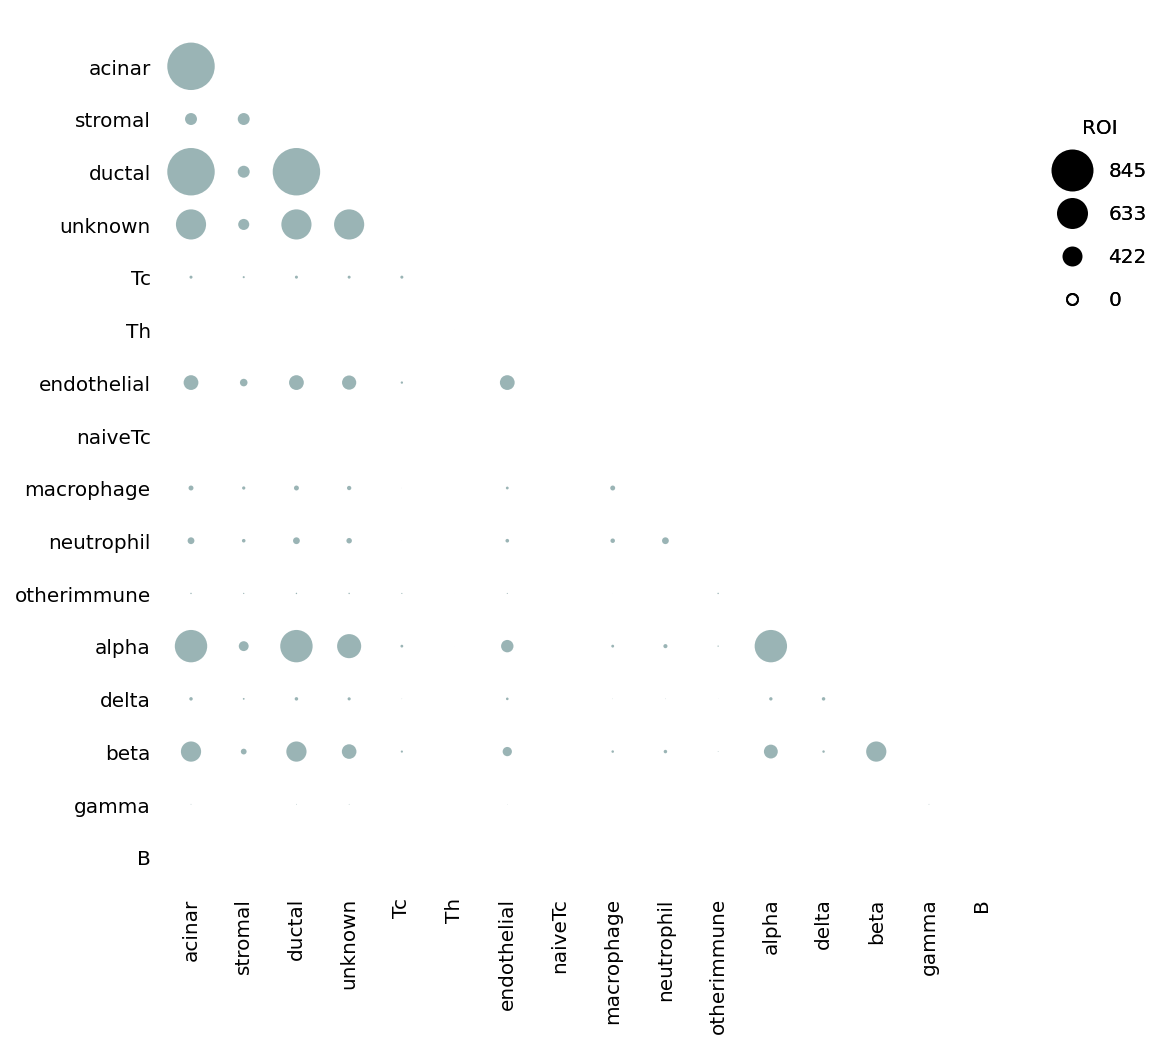

In [16]:
sp.cell_co_occurrence(data)

In [17]:
sp.cell_density(data,
                selected_types=['Tc','naiveTc','Th','B','macrophage','neutrophil'],
                group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],},
                size=(500, 1000))

## Spatial analysis

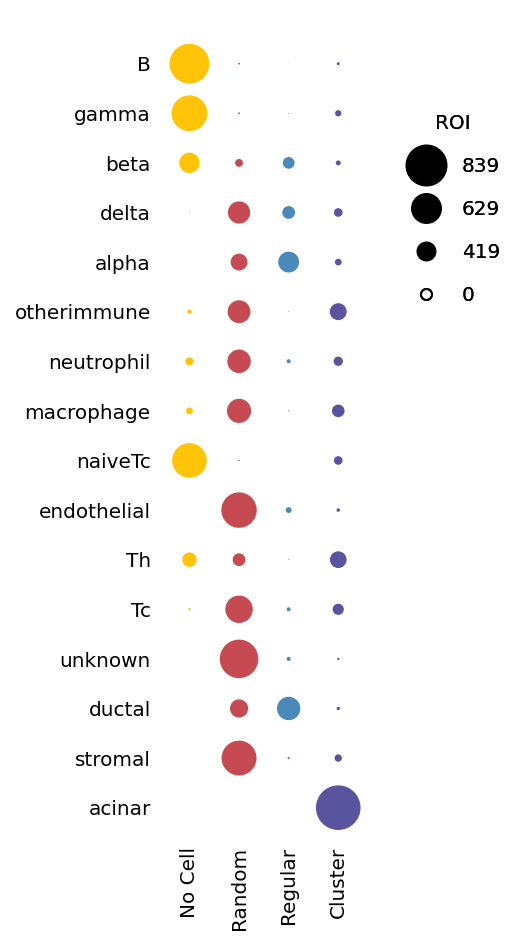

In [18]:
sp.spatial_distribution(data)

In [19]:
sp.spatial_heterogeneity(data, 
                         ['stage'], 
                         group_order={'stage':['Non-diabetic', 'Onset', 'Long-duration'],}, 
                         title="Spatial heterogeneity of diabetes stages",
                        yaxis_title="Heterogeneity")



In [20]:
sp.cell_map(data, {'stage':'Onset', 'case':6414, 'part':'Tail', 'image':'G01'}, type_key="hotspot", geom="point", size=(400, 800))
sp.cell_map(data, {'stage':'Onset', 'case':6414, 'part':'Tail', 'image':'G02'}, type_key="hotspot", geom="point", size=(400, 800))

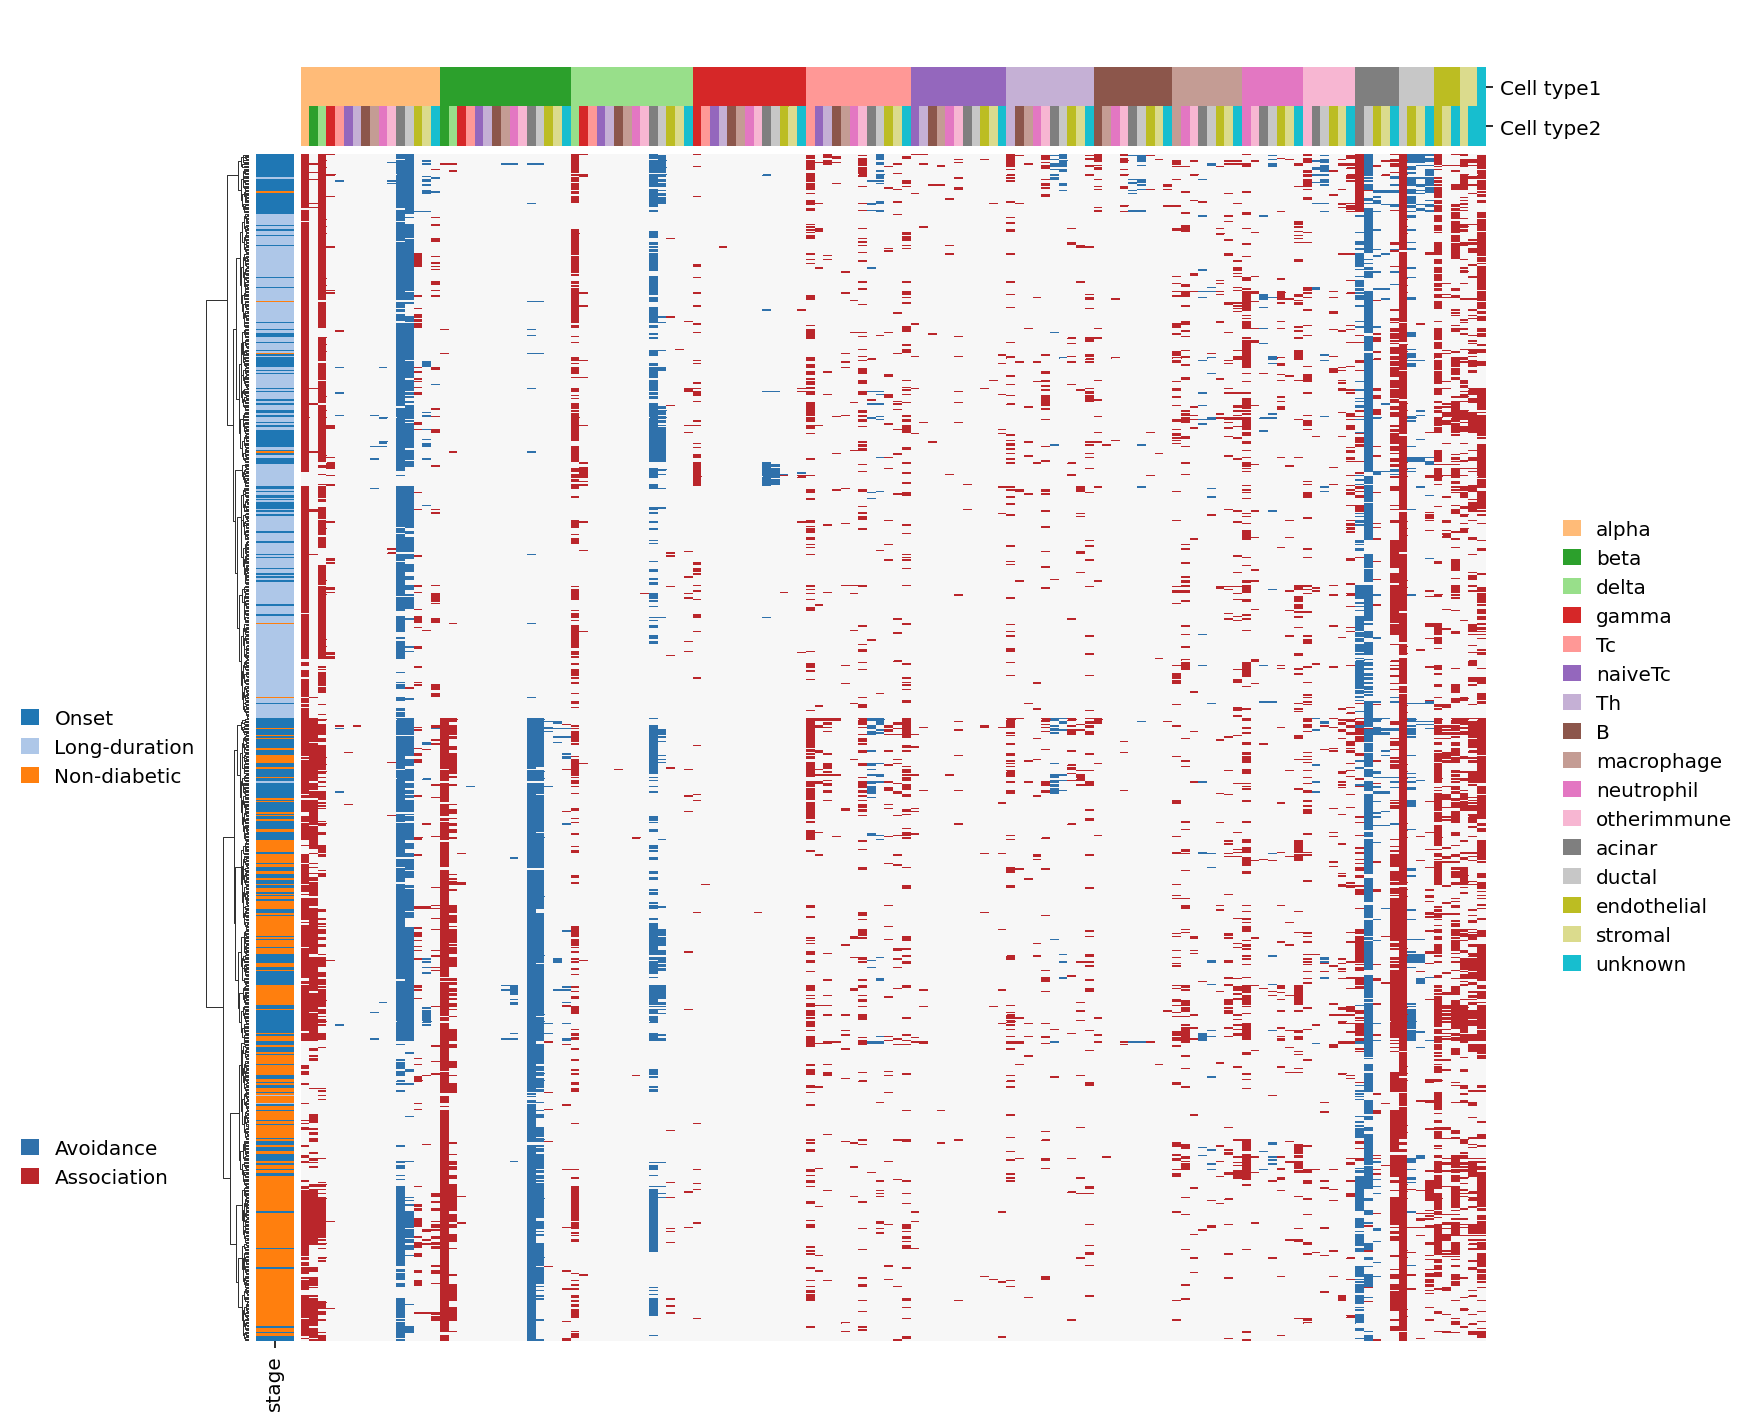

In [21]:
cell_type_order = ['alpha', 'beta', 'delta', 'gamma', 'Tc', 'naiveTc', 'Th', 'B', 'macrophage', 'neutrophil',
                  'otherimmune', 'acinar', 'ductal', 'endothelial', 'stromal', 'unknown']

sns_heatmap_args = dict(row_cluster=True, col_cluster=False, method="ward")

sp.neighborhood_analysis(data, ['stage'], selected_types=cell_type_order, use="heatmap", **sns_heatmap_args)

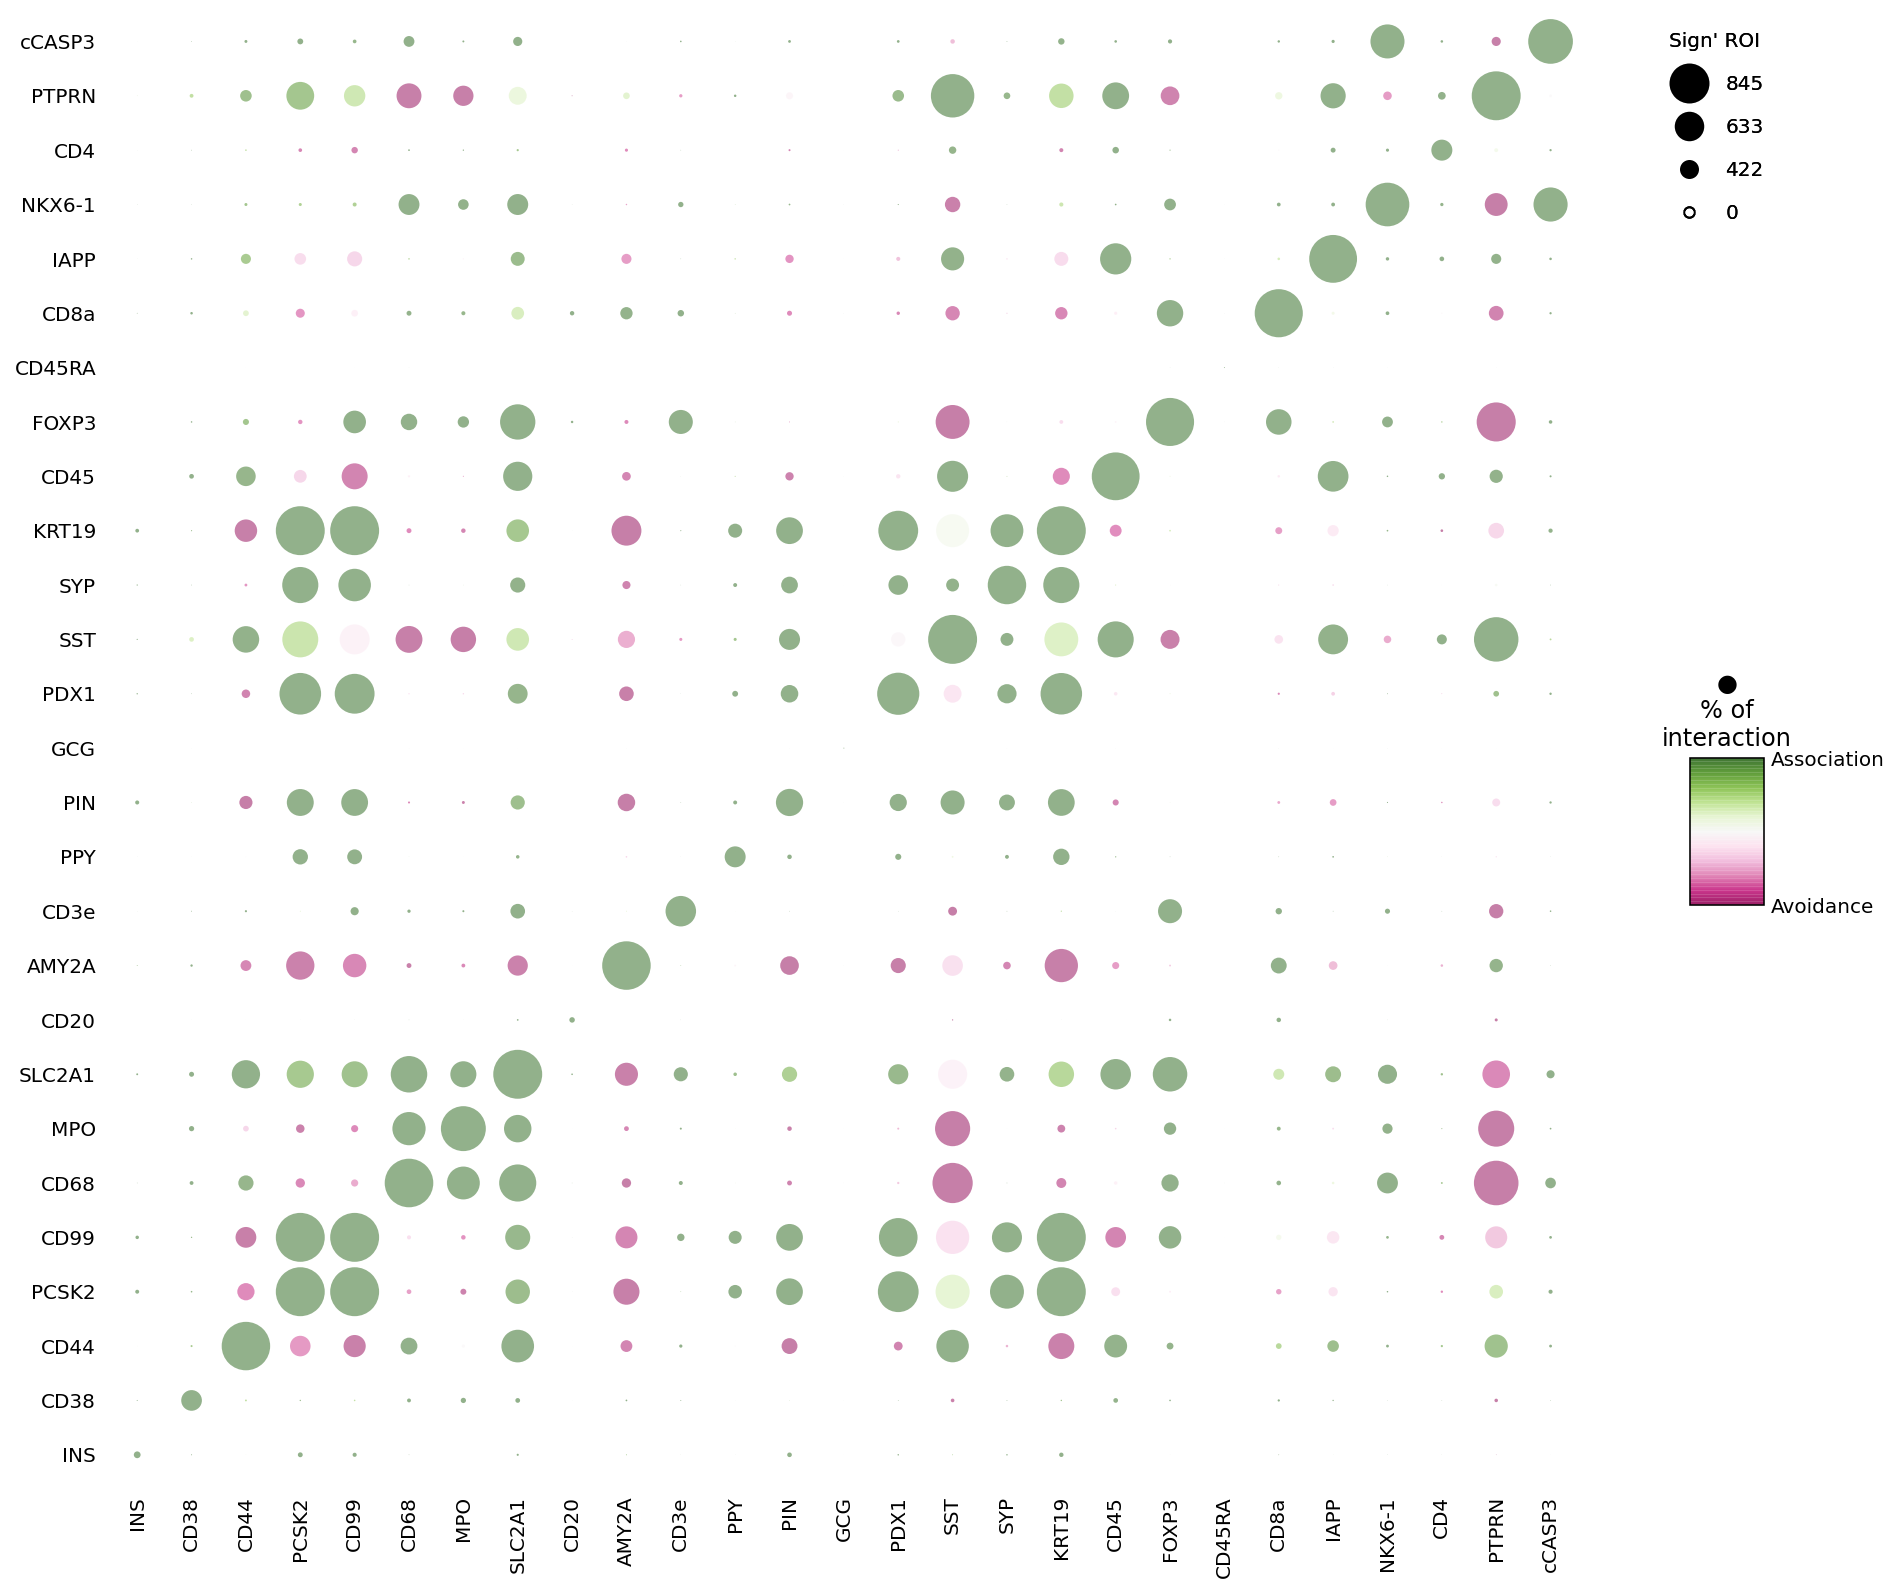

In [24]:
selected_markers=["INS","CD38","CD44","PCSK2","CD99","CD68","MPO","SLC2A1",
"CD20","AMY2A","CD3e","PPY","PIN","GCG","PDX1","SST","SYP","KRT19",
"CD45","FOXP3","CD45RA","CD8a","IAPP","NKX6-1","CD4","PTPRN","cCASP3"]
sp.spatial_enrichment_analysis(data, selected_types=selected_markers)

In [23]:
sp.exp_neighcells(data, score=0.5, size=(300, 120))